# Getting Started

In this notebook we will explore the basic use-case of training and evaluating `franken` on a small dataset of DFT calculations.

We use the H2O data obtained from DFT calculations (using RPBE+D3 theory), originally collected by [Montero de Hijes et al.](https://doi.org/10.1063/5.0197105).

To showcase the sample efficiency of our model - and to fit within a small computational budget - we finetune the [MACE-MP0 foundation model](https://mace-docs.readthedocs.io/en/latest/guide/foundation_models.html) with only 8 new samples.

Note that while the original, zero-shot MACE model has poor accuracy on this dataset (which is out-of-distribution with respect to the foundation model's training data), the finetuned `franken` model is very accurate at predicting energy and forces!

This notebook is also available on [Google colab](https://colab.research.google.com/drive/1SJ10dpYmSIzArd-U2DZQUj-8iQue1_Zp?usp=sharing) for easy running.

In [1]:
try:
    import franken
except ImportError:
    %pip install franken[mace]
    import franken

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import ase.io

import franken.metrics
from franken.datasets.registry import DATASET_REGISTRY
from franken.trainers.rf_cuda_lowmem import RandomFeaturesTrainer
from franken.data.base import BaseAtomsDataset
from franken.backbones.utils import CacheDir
from franken.rf.model import FrankenPotential
from franken.data.base import Target
from franken.config import MaceBackboneConfig, MultiscaleGaussianRFConfig

/home/lbonati@iit.local/software/miniforge3-mamba/envs/franken/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the data

> NOTE: The **cache directory** is used to store model backbones and downloaded datasets.
> it defaults to `$HOME/.franken` for the current user and it can be configured by setting the `$FRANKEN_CACHE_DIR`
> environment variable. For example, if you wish to override the default choice you could run
> ```python
> import os
> os.environ["FRANKEN_CACHE_DIR"] = "/path/to/my/cache/franken-cache"
> ```

We need to configure the GNN backbone we wish to use since the data format depends on which backbone will be loaded.
We will use the [**MACE MP0 small** backbone](https://github.com/ACEsuit/mace-foundations) (identified by its `mace_mp/small` ID), with features extracted at the 2nd layer.

The backbone will be downloaded as necessary into the cache directory.

In [3]:
backbone_id = "mace_mp/small"

gnn_config = MaceBackboneConfig(
    path_or_id=backbone_id,
    interaction_block=2,
)

We use the water dataset which is available in our dataset registry for simplicity. In particular, we load 8 random samples from the training set, and the validation set which contains 189 structures. The dataset will be downloaded into franken's cache directory (`CacheDir.get()`).

To use your own dataset, you can simply point the `data_path` argument to the file of your choice. The main restriction is that the file should be readable with the `ase.io.read` command.

In [4]:
train_path = DATASET_REGISTRY.get_path("water", "val", base_path=CacheDir.get())
val_path = DATASET_REGISTRY.get_path("water", "val", base_path=CacheDir.get())

In [5]:
from ase.io import read,write
train = read(train_path, index=":80")
write("train.xyz",train)
val = read(val_path, index=":20")
write("val.xyz",val)

In [6]:
train_dset_8 = BaseAtomsDataset.from_path(
    data_path=train_path, # or custom "train.xyz"
    split="train",
    num_random_subsamples=8,
    subsample_rng=42,
    gnn_config=gnn_config,
)
train_dl_8 = train_dset_8.get_dataloader(distributed=False)

/home/lbonati@iit.local/software/miniforge3-mamba/envs/franken/lib/python3.13/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


ASE -> MACE (train): 100%|██████████| 8/8 [00:00<00:00, 248.28it/s]


The `split` argument can be either "train", "test" or "val" and is mainly used to configure data normalization: normalizing constants are computed only on the training-set to avoid leakage from train to test data.

In [7]:
val_dset = BaseAtomsDataset.from_path(
    data_path=val_path, # or custom "val.xyz"
    split="val",
    gnn_config=gnn_config,
)
val_dl = val_dset.get_dataloader(distributed=False)

ASE -> MACE (val): 100%|██████████| 189/189 [00:00<00:00, 236.02it/s]


### Training a model

We start in the most explicit setting where all the hyperparameters are set before-hand. Below we describe them one by one in detail.

First we define **the kernel**, and its hyperparameters.
Here we use the multiscale Gaussian kernel, which can fit a range of length-scales $\sigma$ with a single model.
This has the big advantage of requiring little tuning: a range of sensible values of $\sigma$ can be set through the three parameters `"length_scale_low", "length_scale_high", "length_scale_num"`. This is much easier than precisely setting the optimal length0scale, and retains most of the accuracy.

The other parameter is the number of random features, which can generally be set based on how much computing time and memory is available: more random features increase accuracy monotonically, although diminishing returns kick in after $\approx 16000$ random features.

In [8]:
rf_config = MultiscaleGaussianRFConfig(
    num_random_features=512,
    length_scale_low=4.0,
    length_scale_high=24.0,
    length_scale_num=4,
    rng_seed=42,  # for reproducibility
)

The **linear system hyperparameters** are:
 - The L2 regularization weight (`"l2_penalty"`), which should be a small number and can be increased if numerical issues arise.
 - The weight of the forces compared to energies in the overall loss. If `"force_weight"` is closer to 1, the forces have more weight -- which is typically the desired configuration -- while when it is set closer to 0, the energies have more weight.

 It is generally very easy and fast to do a hyperparameter search on these parameters, but for the sake of simplicity here they are defined explicitly.

In [9]:
solver_params = {
    "l2_penalty": [1e-5],
    "force_weight": [0.8],
}

Instantiate classes for the model and for the training algorithm. Check the [documentation](https://franken.readthedocs.io/en/latest/) for a description of each argument.

In [10]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = FrankenPotential(
    gnn_config=gnn_config,
    rf_config=rf_config,
    num_species=2,        # H and O
    jac_chunk_size="auto",    # use 12 to fit in the T4 GPU on colab. You can set it to "auto" to adapt to available GPU memory.
)
trainer = RandomFeaturesTrainer(
    train_dataloader=train_dl_8,
    save_every_model=False,
    device=device,
    save_fmaps=False,
)

Call the `fit` method to **train the model**. A separate model for all parameter possibilities in the `solver_params` dictionary is trained, but note that in this case a single solver-parameter has been specified.

In [11]:
logs, weights = trainer.fit(model, solver_params)

Computing dataset statistics: 100%|██████████| 8/8 [00:00<00:00, 16.47it/s]
/home/lbonati@iit.local/work/code/franken/franken/utils/linalg/cov.py:40: UserWarning: low-memory covariance updates cannot be used because `cupy` is not available. Install `cupy` if you encounter memory problems.
  warnings.warn(
/home/lbonati@iit.local/work/code/franken/franken/utils/linalg/cov.py:127: UserWarning: low-memory covariance updates cannot be used because `cupy` is not available. Install `cupy` if you encounter memory problems.
  warnings.warn(


    covs+coeffs      | 0.2 cfgs/s |  88% | 1 x NVIDIA GeForce RTX 3090

`leading_eig` normalization has high memory usage. If you encounter OOM errors try to disable it.


/home/lbonati@iit.local/work/code/franken/franken/utils/linalg/psdsolve.py:41: UserWarning: low-memory solver cannot be used because `cupy` is not available. Install `cupy` if you encounter memory problems.
  warnings.warn(


Run the model to get **predictions** on the whole validation set. We record simple metrics such as energy and force MAE.

> NOTE: The **forces_mode** parameter can be set to either "torch.func" or "torch.autograd". The two have different performance characteristics: "torch.func" is more suitable when there are many different models being trained (i.e. many different solver hyperparameters) as it can effectively run these in a batch way. When only a few models are present, "torch.autograd" can be much faster. In our testing the cutoff between the two is approximately at 100 models, but this may vary greatly depending on hardware characteristics.

> NOTE: predictions and metric tracking can also be done with the `trainer.evaluate` function.

In [12]:
energy_mae = franken.metrics.init_metric("energy_MAE", device=device)
forces_mae = franken.metrics.init_metric("forces_MAE", device=device)
franken_predictions = []
for atom_data, targets in tqdm(val_dl, desc="Predicting energies and forces"):
    # Move the data to the GPU
    atom_data = atom_data.to(device=device)
    targets = targets.to(device=device)
    pred_e, pred_f = model.energy_and_forces(
        atom_data,
        weights=weights,
        forces_mode="torch.autograd",
        add_energy_shift=True
    )
    predictions = Target(pred_e, pred_f)
    energy_mae.update(predictions, targets)
    forces_mae.update(predictions, targets)
    franken_predictions.append(predictions.to(device="cpu"))
energy_mae = energy_mae.compute().item()
forces_mae = forces_mae.compute().item()

Predicting energies and forces: 100%|██████████| 189/189 [00:03<00:00, 58.12it/s]


In [13]:
print(f"Energy MAE = {energy_mae:.2f} meV/atom")
print(f"Forces MAE = {forces_mae:.2f} meV/Angstrom")

Energy MAE = 0.53 meV/atom
Forces MAE = 29.70 meV/Angstrom


### Compare against zero-shot MACE

To show the magnitude of the improvement in accuracy, we evaluate the corresponding MACE
model zero-shot (i.e. without fine-tuning) on the same water dataset.

In [14]:
from mace.calculators import mace_mp

In [15]:
# We will use the mace_mp/small backbone, same as before.
# The interaction block is not relevant for this experiment.
gnn_config = MaceBackboneConfig(
    path_or_id=backbone_id,
    interaction_block=2,
)

In [16]:
from franken.backbones.utils import get_checkpoint_path

device = "cuda:0" if torch.cuda.is_available() else "cpu"
# get_checkpoint_path will download the checkpoint if it doesn't exist in the franken cache.
macemp0_path = get_checkpoint_path(gnn_config.path_or_id)
zeroshot_macemp = mace_mp(macemp0_path)

Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Using head Default out of ['Default']
Default dtype float32 does not match model dtype float64, converting models to float32.


/home/lbonati@iit.local/software/miniforge3-mamba/envs/franken/lib/python3.13/site-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


In [17]:
# For the data, we will use the ase Atoms object directly
# since `zeroshot_macemp` is an ase Calculator object.
ase_val_dset = ase.io.read(
    DATASET_REGISTRY.get_path("water", "val", base_path=CacheDir.get()),
    index=":"
)

Model and dataset have been loaded, we only need to run the evaluation.

Note that since the model is not calibrated to the potential energy of this system, the ground-truth and predicted energies will have a constant difference
which influences error calculations.
To fix this we compute the error up to the constant difference.

In [18]:
zeroshot_predictions = []
for atom_data in tqdm(ase_val_dset, desc="Predicting energies and forces"):
    zeroshot_macemp.calculate(atoms=atom_data)
    predictions = Target(
        torch.tensor(zeroshot_macemp.results["energy"]),
        torch.from_numpy(zeroshot_macemp.results["forces"])
    )
    zeroshot_predictions.append(predictions)

Predicting energies and forces: 100%|██████████| 189/189 [00:04<00:00, 44.30it/s]


In [19]:
# Here we find the constant correction for the predictions
all_pred_energy = []
all_target_energy = []
for i, atom_data in enumerate(ase_val_dset):
    targets = Target(
        energy=torch.tensor(atom_data.get_potential_energy()).float(),
        forces=torch.from_numpy(atom_data.get_forces()).float(),
    )
    predictions = zeroshot_predictions[i]
    all_target_energy.append(targets.energy)
    all_pred_energy.append(predictions.energy)
constant_difference = torch.tensor(all_pred_energy).mean() - torch.tensor(all_target_energy).mean()

In [20]:
# and finally compute the metrics with corrected free energies
zeroshot_energy_mae = franken.metrics.init_metric("energy_MAE", device="cpu")
zeroshot_forces_mae = franken.metrics.init_metric("forces_MAE", device="cpu")
for i, atom_data in enumerate(ase_val_dset):
    targets = Target(
        energy=torch.tensor(atom_data.get_potential_energy()).float(),
        forces=torch.from_numpy(atom_data.get_forces()).float(),
    )
    zeroshot_predictions[i] = Target(
        energy=zeroshot_predictions[i].energy - constant_difference,
        forces=zeroshot_predictions[i].forces
    )
    zeroshot_energy_mae.update(zeroshot_predictions[i], targets)
    zeroshot_forces_mae.update(zeroshot_predictions[i], targets)
zeroshot_energy_mae = zeroshot_energy_mae.compute().item()
zeroshot_forces_mae = zeroshot_forces_mae.compute().item()

In [21]:
print(f"Zero-shot MACE-MP0 energy error = {zeroshot_energy_mae:.2f} meV/atom")
print(f"Zero-shot MACE-MP0 forces error = {zeroshot_forces_mae:.2f} meV/Angstrom")

Zero-shot MACE-MP0 energy error = 2.34 meV/atom
Zero-shot MACE-MP0 forces error = 132.89 meV/Angstrom


We can also plot the error distribution for both methods to see the large improvement with `franken`

Text(0.5, 1.0, 'Force errors')

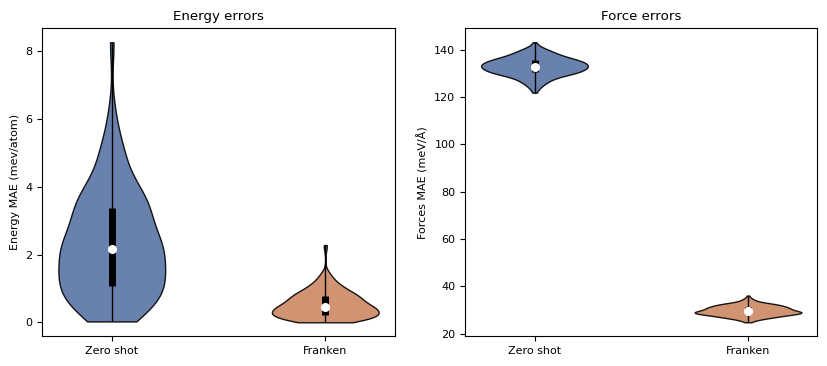

In [22]:
energy_mae = franken.metrics.init_metric("energy_MAE", device="cpu")
forces_mae = franken.metrics.init_metric("forces_MAE", device="cpu")
errors = {
    "energy": {
        "franken": [],
        "zeroshot": []
    },
    "forces": {
        "franken": [],
        "zeroshot": []
    }
}
for i, atom_data in enumerate(ase_val_dset):
    targets = Target(
        energy=torch.tensor(atom_data.get_potential_energy()).float(),
        forces=torch.from_numpy(atom_data.get_forces()).float(),
    )
    energy_mae.update(zeroshot_predictions[i], targets)
    errors["energy"]["zeroshot"].append(energy_mae.compute(reset=True).item())
    energy_mae.update(franken_predictions[i], targets)
    errors["energy"]["franken"].append(energy_mae.compute(reset=True).item())
    forces_mae.update(zeroshot_predictions[i], targets)
    errors["forces"]["zeroshot"].append(forces_mae.compute(reset=True).item())
    forces_mae.update(franken_predictions[i], targets)
    errors["forces"]["franken"].append(forces_mae.compute(reset=True).item())

fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
data = (
    [errors["energy"]["zeroshot"], errors["energy"]["franken"]],
    [errors["forces"]["zeroshot"], errors["forces"]["franken"]]
)
colors = ['#5975A4', '#CC8963']
for i, ax in enumerate(axs):
    quartile1, medians, quartile3 = np.percentile(data[i], [25, 50, 75], axis=1)
    vp = ax.violinplot(data[i], showextrema=False)
    for j, pc in enumerate(vp['bodies']):
        pc.set_facecolor(colors[j])
        pc.set_edgecolor('black')
        pc.set_alpha(0.9)
    ax.scatter([1, 2], medians, marker='o', color='white', s=30, zorder=3)
    ax.vlines([1, 2], quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax.vlines([1, 2], np.min(data[i], axis=1), np.max(data[i], axis=1), color='k', lw=1)
    ax.set_xticks([1, 2], ["Zero shot", "Franken"])
axs[0].set_ylabel("Energy MAE (mev/atom)")
axs[0].set_title("Energy errors")
axs[1].set_ylabel("Forces MAE (meV/Å)")
axs[1].set_title("Force errors")